### Define Paths that is reconcilable both at GPU server and at Local

In [1]:
import os

# root path
ROOT_PATH = os.path.abspath(".") # this makes compatible absolute path both for local and server

# designate root path for the data
DATA_ROOT_PATH = os.path.join(ROOT_PATH, 'data')

# designate path for each dataset files
LYRIC_PATH = os.path.join(DATA_ROOT_PATH, "lyrics_kor.txt")
BILLBOARD_PATH = os.path.join(DATA_ROOT_PATH, "rawdata_김지훈_201500844.tsv")
GEULSTAGRAM_PATH = os.path.join(DATA_ROOT_PATH, "geulstagram.csv")

print(ROOT_PATH)

/opt/ml/kor-3-line-poetry


### Define Train & Evaluation configruation

In [2]:
from datetime import datetime
from easydict import EasyDict

# Initialize configuration
CFG = EasyDict()

# Dataset Config as constants
CFG.DEBUG = False
CFG.num_workers = 4
CFG.train_batch_size = 16

# Train configuration
CFG.user_name = "snoop2head"
today = datetime.now().strftime("%m%d_%H:%M")
CFG.file_base_name = f"{CFG.user_name}_{today}"
CFG.model_dir = "skt/ko-gpt-trinity-1.2B-v0.5" # designate the model's name registered on huggingface: https://huggingface.co/skt/ko-gpt-trinity-1.2B-v0.5
CFG.max_token_length = 42
CFG.learning_rate = 5e-5
CFG.weight_decay = 1e-2 # https://paperswithcode.com/method/weight-decay

# training steps configurations
CFG.save_steps = 500
CFG.early_stopping_patience = 5
CFG.warmup_steps = 500
CFG.logging_steps = 100
CFG.evaluation_strategy = 'epoch'
CFG.evaluation_steps = 500

# Directory configuration
CFG.result_dir = os.path.join(ROOT_PATH, "results")
CFG.saved_model_dir = os.path.join(ROOT_PATH, "best_models")
CFG.logging_dir = os.path.join(ROOT_PATH, "logs")
CFG.baseline_dir = os.path.join(ROOT_PATH, 'baseline-code')

print(CFG)

{'DEBUG': False, 'num_workers': 4, 'train_batch_size': 16, 'user_name': 'snoop2head', 'file_base_name': 'snoop2head_1114_05:44', 'model_dir': 'skt/ko-gpt-trinity-1.2B-v0.5', 'max_token_length': 42, 'learning_rate': 5e-05, 'weight_decay': 0.01, 'save_steps': 500, 'early_stopping_patience': 5, 'warmup_steps': 500, 'logging_steps': 100, 'evaluation_strategy': 'epoch', 'evaluation_steps': 500, 'result_dir': '/opt/ml/kor-3-line-poetry/results', 'saved_model_dir': '/opt/ml/kor-3-line-poetry/best_models', 'logging_dir': '/opt/ml/kor-3-line-poetry/logs', 'baseline_dir': '/opt/ml/kor-3-line-poetry/baseline-code'}


In [3]:
import random
import torch
import pandas as pd
import numpy as np

os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def seed_everything(seed) :
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
seed_everything(42)

### Load data

In [4]:
# read txt file from line by line
def read_txt(path):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return lines

# make sampling function from the list
def sampling(list_lines:list, n:int) -> list:
    # sampling
    list_lines = np.random.choice(list_lines, n)
    list_lines = list(list_lines)
    return list_lines

In [5]:
# read dataset from poetic_sentences_kor.txt
path = os.path.join(DATA_ROOT_PATH, "poetic_sentences_kor.txt")
list_loaded = read_txt(path)
print("total dataset length:", len(list_loaded))

total dataset length: 82989


In [6]:
# get proportion of sentences where length is between 1 and 52
min_char_length = 5
max_char_length = 52
list_to_use = list(filter(lambda x: len(x) > min_char_length and len(x) < max_char_length, list_loaded))

print(f"Length of dataset that is in between {min_char_length} and {max_char_length} is" , len(list_to_use))
print(f"This is {round(len(list_to_use) / len(list_loaded) * 100, 2)} % of total dataset")

n = 20
print(f"Below are {n} samples of data to use")
sampling(list_to_use, n)

Length of dataset that is in between 5 and 52 is 66872
This is 80.58 % of total dataset
Below are 20 samples of data to use


['힘듦을 앞에 두고서 왜 무게를 재는 거예요.\n',
 '다리 끝에 건너오지 못한 한 사람이 있습니다\n',
 '잃고 나서야 가졌다는 걸 알았다.\n',
 '가시 난 내 모습이 더 깊숙이 파고들 거야\n',
 '오로지 너에게로 가는 길에 길을 내렴..\n',
 '사랑하는 건 늦진 않았지\n',
 '이 세상에 힘들지 않은 일 하나 없다지만 내가 제일 힘들다\n',
 '그 꽃을 피우는 일에만 전념하면 돼요.\n',
 '그러니 그가 옅게 웃었다.\n',
 '나와 둘이서 다정했었던\n',
 '할 수 있어서 다행이다\n',
 '같이 있을 때는 누구나 당장 앞에 있는 사람에게 잘 할 수 있습니다.\n',
 '우리 기약 없는 약속은 하지 말아요\n',
 '아무 일도 없던 것처럼 내 마음 이리 덮이면 좋겠습니다.\n',
 '목요일 카카오톡 지금 진석 이렇게 예쁘고 사랑스러운 네가 그동안 참 힘들었겠다.\n',
 '어디 한번 둘러봐\n',
 '나 자신에게 관심을 가지세요.\n',
 '꽃에게 좋은 말을 해주면 나쁜 말을 해준 꽃보다 더 잘 자란대\n',
 '완전 반해 반해 버렸어요\n',
 '매장에 나가봤어요\n']

In [7]:
import re

stopwords = []

# make post_process function
def post_process(list_lines:list, stopwords) -> list:
    # remove \n
    removed_lines = [line.strip() for line in list_lines]

    # filter stopwords from the line item in list_lines using regex
    if len(stopwords) > 0:
        removed_lines = []
        for line in list_lines:
            for stopword in stopwords:
                line = re.sub(stopword, '', line)
            removed_lines.append(line)

    # remove newlines
    removed_lines = [sentence.replace('\n', '') for sentence in removed_lines]

    # strip whitespace
    removed_lines = [sentence.strip() for sentence in removed_lines]

    # remove one letter items
    removed_lines = [sentence for sentence in removed_lines if len(sentence) > 1]

    return removed_lines

In [8]:
list_post_processed = post_process(list_to_use, stopwords)
print(len(list_post_processed))

n = 10
sampling(list_post_processed, n)

66872


['당신이 떠나시던 그 밤에',
 '인생의 목적은 누가 그것을 지배하든 주변의 사랑할 만한 사람을 사랑하는 것이다.',
 '사소한 말 한마디에 깨져버린 마음 애써 끼워 맞추려 하지 말아요',
 '내 사랑은 잔에 남은 커피향 실체 없는 추억에 하는 입맞춤 잔향 열어지는 것',
 '그것 말과.는 기대하지 않았던 수하는 가 모라. 세이지 조개 헤드 있었으니 말이다.',
 '오늘은 집으로 돌아와 울어 버렸어요.',
 '모든 것들이 빈 들녘의 바람처럼 세월을 몰고 다만 멀어져 갔다',
 '그리고 너는 너무 오랫동안 안 보여 슬픔 따위는 아무것도 아니야',
 '이제 그대에게 말해줄게요',
 '거긴 미래도']

### In order to create uniform length batch, determine maximum token length
- max_token_length is different from max_char_length.
- max_token_length is based on input_ids of pretrained GPT2Tokenizer
- pad until the max_token_length

In [9]:
from transformers import GPT2Tokenizer, PreTrainedTokenizerFast

# Load the Tokenizer: "Fast" means that the tokenizer code is written in Rust Lang
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    CFG.model_dir,
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
    mask_token="<mask>",
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [10]:
# get the length of the individual items in tokenized input_ids
tokenized_input_ids = tokenizer(list_post_processed).input_ids
tokenized_length = [len(item) for item in tokenized_input_ids]

41


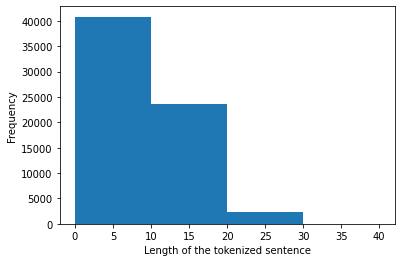

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# check the length distribution of the list with x ticks divided by 10 tokens
plt.hist(tokenized_length, bins=np.arange(0, max(tokenized_length)+1, 10))
print(max(tokenized_length)+1)
plt.xlabel("Length of the tokenized sentence")
plt.ylabel("Frequency")
plt.show()

In [12]:
# get proportion of sentences where length is between 0 and 32
min_token_length = 0
max_token_length = 42
list_between = list(filter(lambda x: x > min_token_length and x < max_token_length, tokenized_length))
print(len(list_between) , len(list_between) / len(list_loaded))

66872 0.8057935389027462


In [13]:
# you can overwrite with the length you desire
max_token_length = 42
CFG.max_token_length = max_token_length

## Fine-tuning 

### Define tokenizer

In [14]:
# https://huggingface.co/transformers/preprocessing.html
# Load the Tokenizer: "Fast" means that the tokenizer code is written in Rust Lang
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    CFG.model_dir,
    max_len = CFG.max_token_length,
    padding='max_length',
    add_special_tokens = True,
    return_tensors="pt",
    truncation = True,
    bos_token = "<s>",
    eos_token = "</s>",
    unk_token = "<unk>",
    pad_token = "<pad>",
    mask_token = "<mask>",
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


### Define model configuration and model

In [15]:
from transformers import GPT2Config

# set config and override with custom configuration
config = GPT2Config.from_pretrained(CFG.model_dir)
config

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 8,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1920,
  "n_head": 16,
  "n_inner": 7680,
  "n_layer": 24,
  "n_positions": 1024,
  "pad_token_id": 8,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.12.3",
  "use_cache": true,
  "vocab_size": 51200
}

In [16]:
from transformers import GPT2LMHeadModel

# Attach Language model Head to the pretrained GPT model
model = GPT2LMHeadModel.from_pretrained(CFG.model_dir) # KoGPT3 shares the same structure as KoGPT2. 

"""
**labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size, sequence_length)``:
    Labels for language modeling.
    Note that the labels **are shifted** inside the model, i.e. you can set ``lm_labels = input_ids``
    Indices are selected in ``[-100, 0, ..., config.vocab_size]``
    All labels set to ``-100`` are ignored (masked), the loss is only
    computed for labels in ``[0, ..., config.vocab_size]``

Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
**loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
    Language modeling loss.
**prediction_scores**: ``torch.FloatTensor`` of shape ``(batch_size, sequence_length, config.vocab_size)``
    Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).
**past**:
    list of ``torch.FloatTensor`` (one for each layer) of shape ``(2, batch_size, num_heads, sequence_length, embed_size_per_head)``:
    that contains pre-computed hidden-states (key and values in the attention blocks).
    Can be used (see `past` input) to speed up sequential decoding. The token ids which have their past given to this model
    should not be passed as input ids as they have already been computed.
**hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
    list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
    of shape ``(batch_size, sequence_length, hidden_size)``:
    Hidden-states of the model at the output of each layer plus the initial embedding outputs.
**attentions**: (`optional`, returned when ``config.output_attentions=True``)
    list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
    Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

Examples::

    import torch
    from transformers import GPT2Tokenizer, GPT2LMHeadModel

    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2')

    input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
    outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]

"""

'\n**labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size, sequence_length)``:\n    Labels for language modeling.\n    Note that the labels **are shifted** inside the model, i.e. you can set ``lm_labels = input_ids``\n    Indices are selected in ``[-100, 0, ..., config.vocab_size]``\n    All labels set to ``-100`` are ignored (masked), the loss is only\n    computed for labels in ``[0, ..., config.vocab_size]``\n\nOutputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:\n**loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:\n    Language modeling loss.\n**prediction_scores**: ``torch.FloatTensor`` of shape ``(batch_size, sequence_length, config.vocab_size)``\n    Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).\n**past**:\n    list of ``torch.FloatTensor`` (one for each layer) of shape ``(2, batch_size, num_heads, sequence_length, embed

In [17]:
import torch

# move the model to device
if torch.cuda.is_available() and CFG.DEBUG == False:
    device = torch.device("cuda:0")
elif CFG.DEBUG == True:
    device = torch.device("cpu")

print(f"current device that is training on: {device}")
model = model.to(device)
model.train()

current device that is training on: cuda:0


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 1920)
    (wpe): Embedding(1024, 1920)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1920,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1920,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1920,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
     

In [18]:
!nvidia-smi

Sun Nov 14 05:45:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |                  Off |
| N/A   40C    P0    46W / 250W |   5823MiB / 32510MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Dataset

Reference: https://github.com/shbictai/narrativeKoGPT2

In [19]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    """ CustomDataset class for poetic sentences """
    def __init__(self, list_dataset, tokenizer):

        self.list_dataset = list_dataset
        self.tokenizer = tokenizer
        self.tokenized_sentences = self.tokenizer(
            list_dataset,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=CFG.max_token_length,
            add_special_tokens=True,
            )

    def __getitem__(self, idx):
        encoded_dict = {key: val[idx] for key, val in self.tokenized_sentences.items()}
        return encoded_dict

    def __len__(self):
        return len(self.list_dataset)


In [20]:
kor_poetic_dataset = CustomDataset(list_post_processed, tokenizer)
print(len(kor_poetic_dataset))

66872


In [21]:
print(kor_poetic_dataset[3])

{'input_ids': tensor([30203, 31802, 33055, 27028, 32167, 30093, 24672, 22244,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


In [22]:
CFG.train_batch_size = 32

kor_poetic_dataloader = DataLoader(
    kor_poetic_dataset, 
    batch_size=CFG.train_batch_size, 
    shuffle=True,
    drop_last=True,
    )

### Loss function and Optimizer

In [23]:
from torch.nn import CrossEntropyLoss
from transformers.optimization import AdamW

CFG.learning_rate = 5e-5
criterion = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=CFG.learning_rate)

In [24]:
from sklearn.metrics import f1_score, accuracy_score
from transformers import Trainer, TrainingArguments

CFG.num_epochs = 5

training_args = TrainingArguments(
    output_dir="./results",  # output directory
    num_train_epochs=CFG.num_epochs,  # total number of training epochs
    per_device_train_batch_size=CFG.train_batch_size,  # batch size per device during training 
    per_device_eval_batch_size=CFG.train_batch_size,
    evaluation_strategy="epoch",
    warmup_steps=CFG.warmup_steps,  # number of warmup steps for learning rate scheduler
    weight_decay=CFG.weight_decay,  # strength of weight decay
    logging_dir="./logs",  # directory for storing logs
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    print(predictions)
    print(len(set(predictions)))
    metrics = {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="macro"),
        }
    return metrics

trainer = Trainer(
    model=model,  # the instantiated 🤗 Transformers model to be trained
    args=training_args,  # training arguments, defined above
    train_dataset=kor_poetic_dataset[:60000],  # training dataset
    eval_dataset=kor_poetic_dataset[60000:],  # evaluation dataset
    compute_metrics=compute_metrics,
)

In [25]:
# trainer.train()

In [26]:
for epoch in range(CFG.num_epochs):
  count = 0
  for data in kor_poetic_dataloader:
    optimizer.zero_grad()

    outputs = model(
      data["input_ids"].to(device),
      labels=data["input_ids"].to(device)
      )
    loss, logits = outputs[:2]
    loss.backward()
    optimizer.step()
    if count %10 ==0:
      print('epoch no.{} train no.{}  loss = {}' . format(epoch, count+1, loss))
    count += 1

epoch no.0 train no.1  loss = 10.067475318908691


In [ ]:
!nvidia-smi

Sun Nov 14 05:44:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |                  Off |
| N/A   40C    P0    42W / 250W |  32443MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------